In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
users = np.loadtxt('../processed_data/last_fm/lfm_u_1.txt')
data = np.loadtxt('../processed_data/last_fm/lfm_a_1.txt')
output_score_file = "../ndcg_scores/rba_klucb/score_lfm_u_1.txt"
users = np.ones(users.size)
ones = 1 # change for each file depending upon no. of ones.
timesteps = users.size
#timesteps = 11
no_recommendation = data.shape[1]
times_appeared = []
weight = []
scores = np.zeros(timesteps)
best_dcg = 0.0
for i in range(0,ones):
    best_dcg += 1.0/np.log2(i+2)

In [3]:
def initialize():
    for i in range(0,no_recommendation):
        times_appeared.append({})
        weight.append({})

In [4]:
def receive_user(t):
    return users[t]

def receive_items(t):
    return data[t]


In [5]:
def klbern(x, y):
    
    eps = 1e-9
    x = min(max(x, eps), 1 - eps)
    y = min(max(y, eps), 1 - eps)
    return x * np.log2(x / y) + (1 - x) * np.log2((1 - x) / (1 - y))

def klucb(w,times , t):
   
    l = w
    u = 1.0
    precision=1e-3
    d = (np.log2(t) + 3*np.log2(np.log2(t+1)))/times
    
    while u - l > precision:
        m = (l + u) / 2
        if klbern(w, m) > d:
            u = m
        else:
            l = m
    return (l + u) / 2

In [6]:
def mab(pos,u,items,t):
    if not u in times_appeared[pos]:
        times_appeared[pos][u] = {}
        weight[pos][u] = {}
    for i in range(0,items.size):
        if not items[i] in times_appeared[pos][u]:
            times_appeared[pos][u][items[i]] = 1.0
            weight[pos][u][items[i]] = np.random.uniform(low=0.001,high=0.01,size=1)
    ucb = np.zeros(no_recommendation)
    for i in range(0,no_recommendation):
        ucb[i] = klucb(weight[pos][u][items[i]],times_appeared[pos][u][items[i]],t+1)
    return items[np.argmax(ucb)]

In [7]:
def rba(u,items,t):
    original_ranked = np.zeros(no_recommendation)-1
    final_ranked = np.zeros(no_recommendation)-1
    
    for i in range(0,no_recommendation):
        original_ranked[i] = mab(i,u,items,t)
        if np.in1d(original_ranked[i],final_ranked[0:i],assume_unique=True)[0] == True:
            final_ranked[i] = np.random.choice(np.setdiff1d(items,final_ranked[0:i],assume_unique=True),size=1)
        else:
            final_ranked[i] = original_ranked[i]
            
    return final_ranked,original_ranked
    

In [8]:
def simulate_click(items,ranked_items):
    
    clicked = np.zeros(items.size)
    for i in range(0,items.size):
        for j in range(0,ones):
            if items[j] == ranked_items[i]:
                clicked[i] = 1
                
    return clicked

In [9]:
def score(t,clicked):
    for i in range(0,clicked.size):
        scores[t] += clicked[i]/np.log2(i+2)
    scores[t] /= best_dcg

In [10]:
def update(u,original_ranked_items,final_ranked_items,clicked):
    for i in range(0,no_recommendation):
        if original_ranked_items[i] == final_ranked_items[i]:
            weight[i][u][final_ranked_items[i]] = (times_appeared[i][u][final_ranked_items[i]]*weight[i][u][final_ranked_items[i]]+clicked[i])/(times_appeared[i][u][final_ranked_items[i]]+1)
            times_appeared[i][u][final_ranked_items[i]] += 1

In [11]:
initialize()
start_time = time.time()
for t in range(0,timesteps):
    #if t%100 == 0:
    #    print t
    u = receive_user(t)
    items = receive_items(t)
    #print items
    final_ranked_items,original_ranked_items = rba(u,items,t)
    clicked = simulate_click(items,final_ranked_items)
    score(t,clicked)
    #print clicked
    #print final_ranked_items
    update(u,original_ranked_items,final_ranked_items,clicked)
end_time = time.time()

In [12]:
for t in range(1,timesteps):
    scores[t] += scores[t-1]

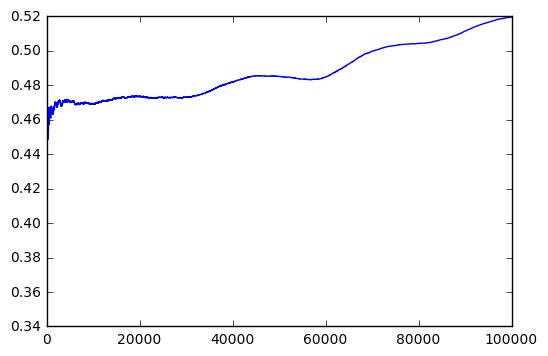

In [13]:
avg = np.zeros(timesteps)
for t in range(0,timesteps):
    avg[t] = scores[t]/(t+1)
plt.plot(avg)
plt.show()

In [14]:
print "Time taken by the algorithm to run is %lf seconds" %(end_time-start_time)
np.savetxt(output_score_file,avg,fmt="%.3f",delimiter=' ')

Time taken by the algorithm to run is 2597.497103 seconds
